In [36]:

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from glob import glob
import os
import os.path as osp
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [37]:
def load_numpy(path):
    return np.load(path)

def get_Dict(filePath):
    arr_list =[]
    for i in glob(osp.join(filePath,'*.npy')):
        print(i)
        arr_list.append(load_numpy(i))
    return arr_list

def get_Hash_path(basePath):
    Hash_Dict={i:osp.join(basePath,i) for i in os.listdir(basePath)}
    return Hash_Dict

def get_Hash_ref_path(ref_path):
    pathDict_ = {}
    for i in glob(osp.join(ref_path,'*','*.csv')):
        filename = i.split('/')[-1].split('.csv')[0]
        pathDict_[filename]=i
    return pathDict_

def time_2_frame(series,start_index_query):
    fps=86
    series['Starttime'] = int(np.floor(series['Starttime']*fps)-start_index_query)
    series['Endtime'] = int(np.floor(series['Endtime']*fps)-start_index_query)
    return series

def make_target(nframes,target_pd):
    total_frame = np.zeros(nframes)
    for start,end in list(zip(target_pd['Starttime'][0],target_pd['Endtime'][0])):
        total_frame[int(start):int(end)]=1.0
    # hop=86
    # seg_len = 431
    # start =int(0) 
    # end = int(start+seg_len)
    # targets=[]
    # while end<nframes:
    #     window = total_frame[start:end]
    #     targets.append(window)
    #     start+=hop
    #     end=start+seg_len
    # targets.append(total_frame[start-(end-nframes):])
    # targets = np.array(targets)
    return np.int_(total_frame)

def update_fileName(series):
    series['Audiofilename'] = series['Audiofilename'].split(".")[0]
    return series

def flatten_res(detections,hop_seg,nframe):
    x = detections
    seg_num,seg_len,bins= x.shape

    y = np.zeros((nframe,bins),dtype=x.dtype)
    for i in range(seg_num-2):
        y[(i+1)*hop_seg:(i+2)*hop_seg] = x[i,hop_seg:2*hop_seg]
    y[:hop_seg] = x[0,:hop_seg]
    y[(seg_num-1)*hop_seg:nframe,:] = x[seg_num-1,-(nframe-(seg_num-1)*hop_seg):,:]
    return y



In [38]:
import pandas as pd
import h5py
import json

def plot_scatter(search_name="n1",basePath="./out_numpy_4CNN_Block_mutitask",waveFramePath='.',PathSet=None):
    h5path = "/media/b227/0090ae43-1009-4c49-a645-e82a32b74d82/b227/ygw/Dcase2021/Development_Set/Features1/feat_eval/"
    file_name = search_name
    search_h5path = h5path+search_name+".h5"
    nframe_path = osp.join(waveFramePath,search_name,"waveFrame.json") 
    refbase_path = "/media/b227/0090ae43-1009-4c49-a645-e82a32b74d82/b227/ygw/Dcase2021/Development_Set/Validation_Set"
    ref_datasetPath = get_Hash_ref_path(refbase_path)
    
    ref_pd = pd.read_csv(ref_datasetPath[file_name]).apply(update_fileName,axis=1)
    ref_pd_POS =ref_pd[ref_pd['Q']=='POS']
    target_pd =ref_pd_POS[ref_pd_POS['Audiofilename']==file_name].reset_index().drop('index',axis=1)
    start_index_query = int(h5py.File(search_h5path,'r')['start_index_query'][:][0])
    nframes = int(json.load(open(nframe_path,'r'))['nframe'])-start_index_query
    target_pd=target_pd.apply(lambda x:time_2_frame(x,start_index_query),axis=1).iloc[5:,:]
    target_pd=target_pd.reset_index().drop('index',axis=1)
    target_pd=target_pd.groupby(by='Audiofilename',as_index=False).agg(list)
    targets = make_target(nframes,target_pd)
    data= get_Dict(PathSet[search_name])
    query = data[-1]
    query = flatten_res(query,86,nframes)
    print("start pca!")
    pca = TSNE(n_components=3,init='pca',random_state=42,learning_rate='auto')
    query_pca = pca.fit_transform(query)
    print("pca finished!")

    def get_event_class_center(pca_feature,target_pd):
        neg_start=0
        pos_=[]
        neg_=[]
        start_tims = target_pd['Starttime'][0]
        end_tims = target_pd['Endtime'][0]
        for s,e in zip(start_tims,end_tims):
            neg_.append(pca_feature[int(neg_start):int(s),:].mean(0))
            pos_.append(pca_feature[int(s):int(e),:].mean(0))
            neg_start=e
        neg_.append(pca_feature[int(neg_start):].mean(0))
        return np.array(neg_),np.array(pos_)
    neg_,pos_ = get_event_class_center(query_pca,target_pd)
    if not osp.exists(osp.join(basePath,search_name,'pca')):
        path = osp.join(basePath,search_name,'pca')
        os.makedirs(path)
    np.save(osp.join(basePath,search_name,'pca','neg.npy'),neg_)
    np.save(osp.join(basePath,search_name,'pca','pos.npy'),pos_)
    fig=plt.figure(figsize=(6,5))
    axes = fig.add_subplot(111)
    # for sub_neg in neg_:
    # #     typep1 = axes.scatter(sub_neg[:,0],sub_neg[:,1],c='y',marker='s')
    # # for sub_pos in pos_:
    # #     typep2 = axes.scatter(sub_pos[:,0],sub_pos[:,1],c='r',marker='o')
    typep2 = axes.scatter(pos_[:,0],pos_[:,1],c='r',marker='o')
    typep1 = axes.scatter(neg_[:,0],neg_[:,1],c='b',marker='s')
    print(search_name)
    plt.title(search_name)
    # ax.view_init(elev=40,azim=20)
    plt.show()

basePath = "./out_numpy_4CNN_Block_mutitask"
waveFramePath = "./waveFrame/"
PathSet = get_Hash_path(basePath)
plot_scatter('n1',basePath=basePath,waveFramePath=waveFramePath,PathSet=PathSet)

./out_numpy_4CNN_Block_mutitask/n1/s_embedding.numpy.npy
./out_numpy_4CNN_Block_mutitask/n1/y_s.numpy.npy
./out_numpy_4CNN_Block_mutitask/n1/q_embedding.numpy.npy
start pca!


KeyboardInterrupt: 

  0%|          | 0/8 [00:00<?, ?it/s]

a1
./out_numpy_4CNN_Block_singleTask/a1/s_embedding.numpy.npy
./out_numpy_4CNN_Block_singleTask/a1/y_s.numpy.npy
./out_numpy_4CNN_Block_singleTask/a1/q_embedding.numpy.npy
start pca!
pca finished!
a1


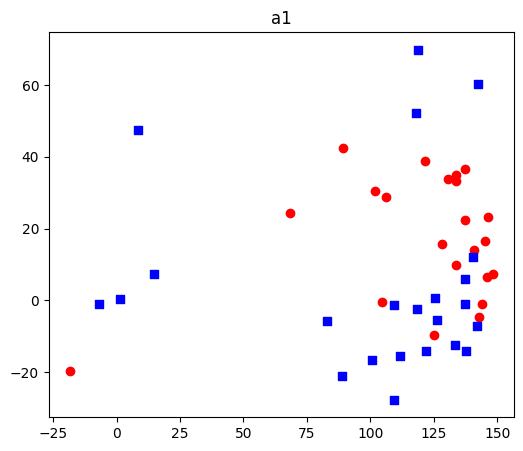

 12%|█▎        | 1/8 [16:14<1:53:42, 974.65s/it]

BUK1_20181013_023504
./out_numpy_4CNN_Block_singleTask/BUK1_20181013_023504/s_embedding.numpy.npy
./out_numpy_4CNN_Block_singleTask/BUK1_20181013_023504/y_s.numpy.npy
./out_numpy_4CNN_Block_singleTask/BUK1_20181013_023504/q_embedding.numpy.npy
start pca!


In [6]:
from tqdm import tqdm
def search_scatters(basePath='.'):
    waveFramePath = "./waveFrame/"
    PathSet = get_Hash_path(basePath)
    for i in tqdm(os.listdir(basePath)):
        if osp.isdir(osp.join(basePath,i)):
            print(i)
            plot_scatter(i,basePath=basePath,waveFramePath=waveFramePath,PathSet=PathSet)
            
basePath="./out_numpy_4CNN_Block_singleTask"
search_scatters(basePath)

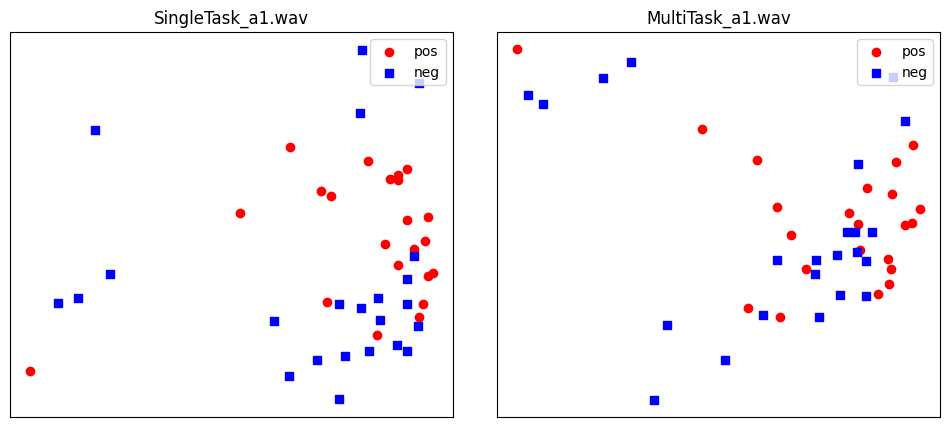

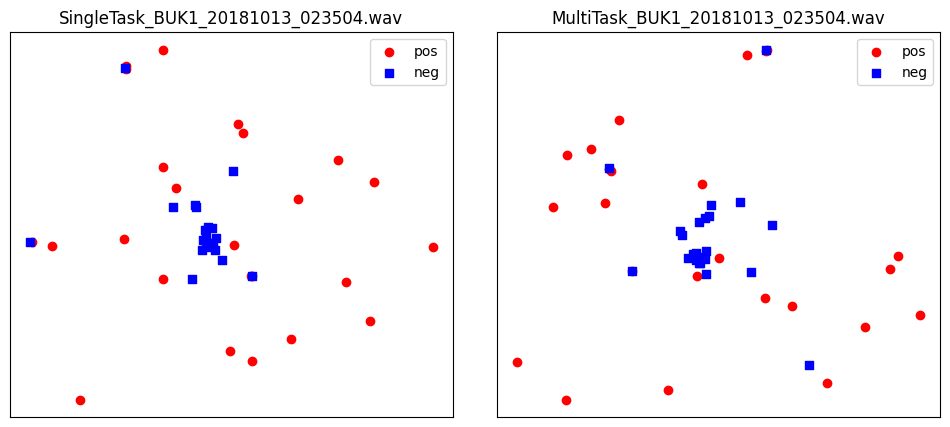

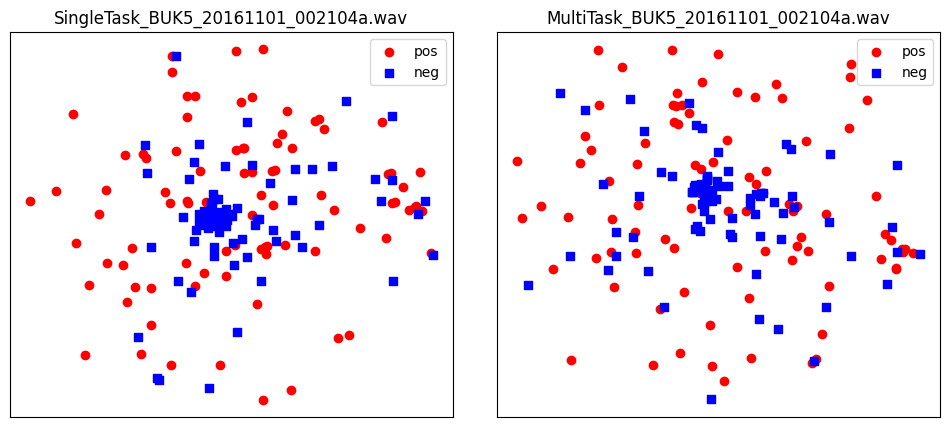

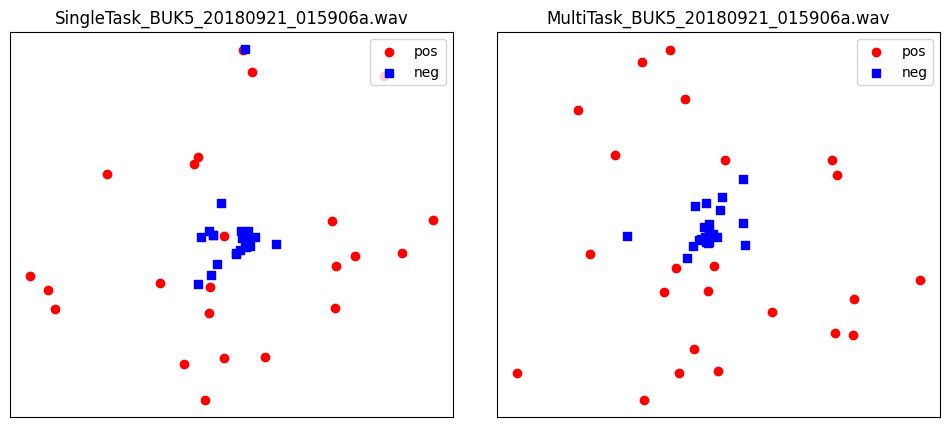

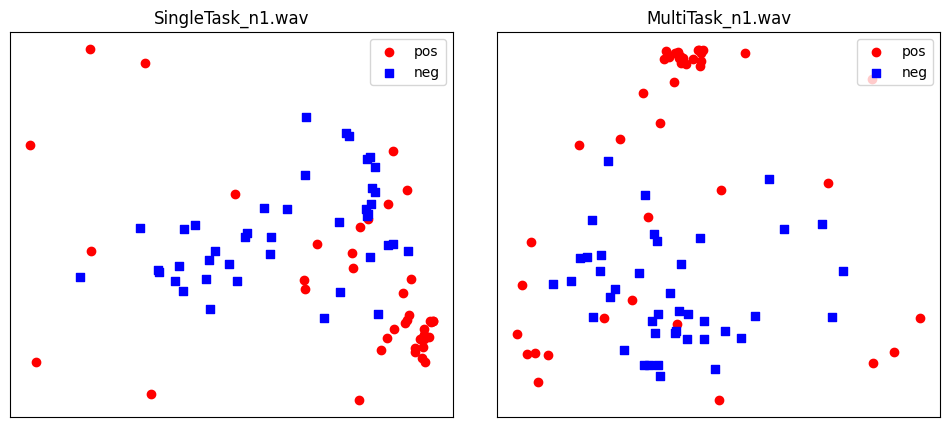

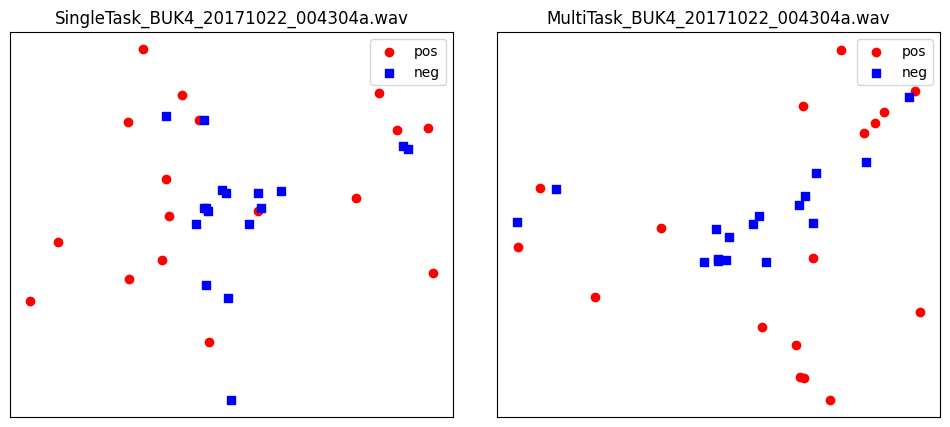

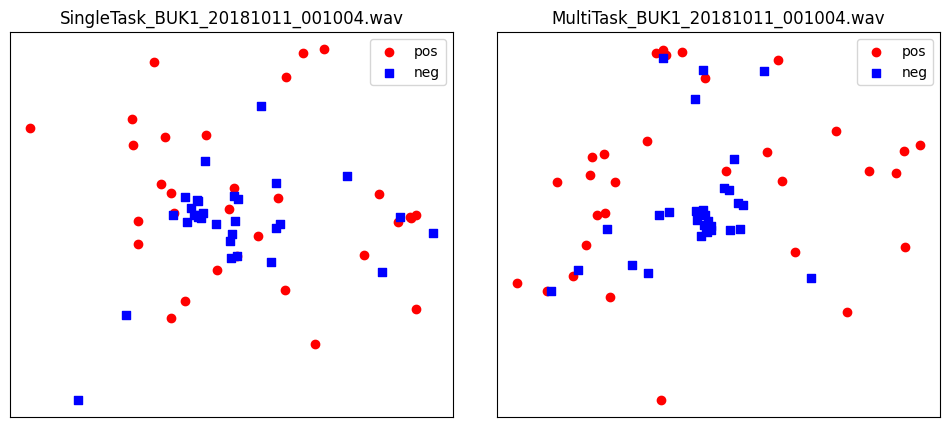

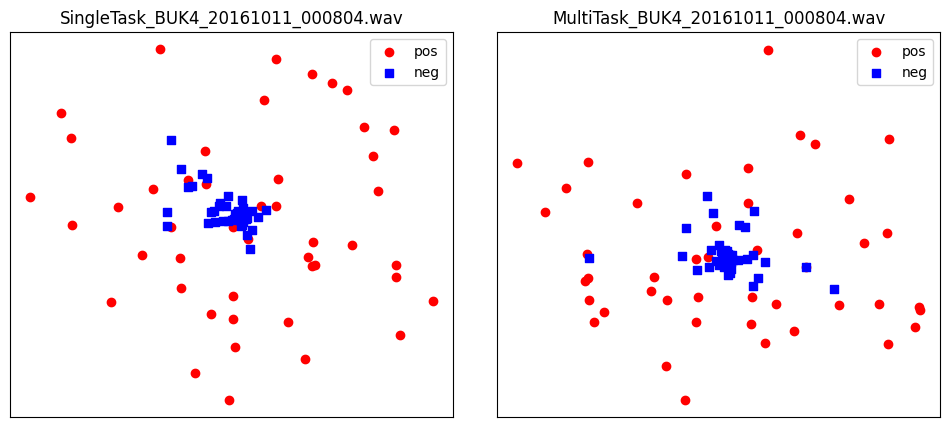

In [32]:
single_task_path = "./out_numpy_4CNN_Block_singleTask"
muti_task_path = "./out_numpy_4CNN_Block_mutitask"

for search_name in os.listdir(muti_task_path):
    if not osp.isdir(osp.join(muti_task_path,search_name)):continue
    # search_name = 'a1'
    single_task_pos =np.load(osp.join(single_task_path,search_name,'pca','pos.npy'))
    single_task_neg =np.load(osp.join(single_task_path,search_name,'pca','neg.npy'))

    muti_task_pos = np.load(osp.join(muti_task_path,search_name,'pca','pos.npy'))
    muti_task_neg = np.load(osp.join(muti_task_path,search_name,'pca','neg.npy'))
    fig=plt.figure(figsize=(12,5))
    fig.add_subplot(121)
    px1=plt.scatter(single_task_pos[:,0],single_task_pos[:,1],c='r',marker='o')
    px2=plt.scatter(single_task_neg[:,0],single_task_neg[:,1],c='b',marker='s')
    plt.legend(['pos','neg'],loc="upper right")
    plt.xticks([])
    plt.yticks([])
    plt.title("SingleTask_"+search_name+'.wav')
    # plt.xlabel(")
    fig.add_subplot(122)
    px1=plt.scatter(muti_task_pos[:,0],muti_task_pos[:,1],c='r',marker='o')
    px2=plt.scatter(muti_task_neg[:,0],muti_task_neg[:,1],c='b',marker='s')
    plt.legend(['pos','neg'],loc="upper right")
    plt.xticks([])
    plt.yticks([])
    plt.title("MultiTask_"+search_name+'.wav')

    plt.subplots_adjust(wspace=0.1)

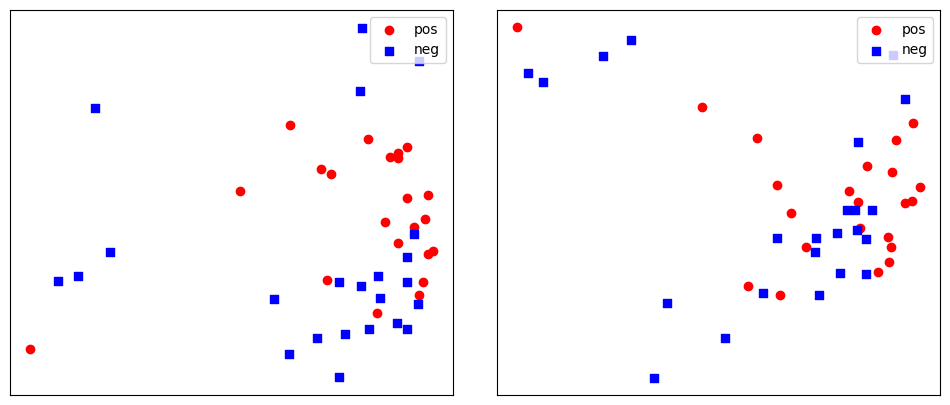

In [26]:
### plot scatters


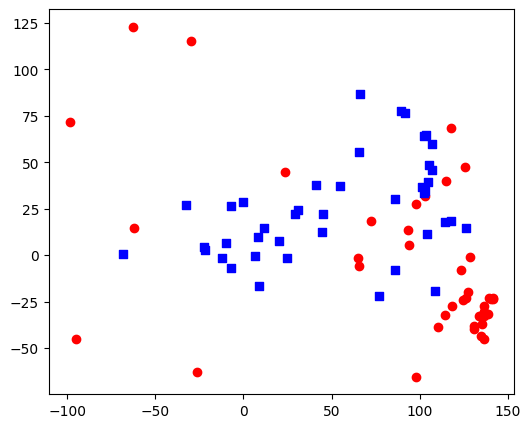

In [7]:
fig=plt.figure(figsize=(6,5))
axes = fig.add_subplot(111)
typep2 = axes.scatter(single_task_pos[:,0],single_task_pos[:,1],c='r',marker='o')
typep1 = axes.scatter(single_task_neg[:,0],single_task_neg[:,1],c='b',marker='s')
plt.show()

In [33]:
for search_name in os.listdir(muti_task_path):
    print(search_name)

a1
BUK1_20181013_023504
Eval_out_tim_post.csv
BUK5_20161101_002104a
BUK5_20180921_015906a
n1
BUK4_20171022_004304a
BUK1_20181011_001004
BUK4_20161011_000804


In [44]:
def plot_scatter(search_name="n1",basePath="./out_numpy_4CNN_Block_mutitask",waveFramePath='.',PathSet=None):
    h5path = "/media/b227/0090ae43-1009-4c49-a645-e82a32b74d82/b227/ygw/Dcase2021/Development_Set/Features1/feat_eval/"
    file_name = search_name
    search_h5path = h5path+search_name+".h5"
    nframe_path = osp.join(waveFramePath,search_name,"waveFrame.json") 
    refbase_path = "/media/b227/0090ae43-1009-4c49-a645-e82a32b74d82/b227/ygw/Dcase2021/Development_Set/Validation_Set"
    ref_datasetPath = get_Hash_ref_path(refbase_path)
    
    ref_pd = pd.read_csv(ref_datasetPath[file_name]).apply(update_fileName,axis=1)
    ref_pd_POS =ref_pd[ref_pd['Q']=='POS']
    target_pd =ref_pd_POS[ref_pd_POS['Audiofilename']==file_name].reset_index().drop('index',axis=1)
    start_index_query = int(h5py.File(search_h5path,'r')['start_index_query'][:][0])
    nframes = int(json.load(open(nframe_path,'r'))['nframe'])-start_index_query
    target_pd=target_pd.apply(lambda x:time_2_frame(x,start_index_query),axis=1).iloc[5:,:]
    target_pd=target_pd.reset_index().drop('index',axis=1)
    target_pd=target_pd.groupby(by='Audiofilename',as_index=False).agg(list)
    targets = make_target(nframes,target_pd)
    data= get_Dict(PathSet[search_name])
    query = data[-1]
    query = flatten_res(query,86,nframes)
    print("start pca!")
    pca = TSNE(n_components=3,init='pca',random_state=42,learning_rate='auto')
    query_pca = pca.fit_transform(query)
    print("pca finished!")

    def get_event_class_center(pca_feature,target_pd):
        neg_start=0
        pos_=[]
        neg_=[]
        start_tims = target_pd['Starttime'][0]
        end_tims = target_pd['Endtime'][0]
        for s,e in zip(start_tims,end_tims):
            neg_.append(pca_feature[int(neg_start):int(s),:].mean(0))
            pos_.append(pca_feature[int(s):int(e),:].mean(0))
            neg_start=e
        neg_.append(pca_feature[int(neg_start):].mean(0))
        return np.array(neg_),np.array(pos_)
    neg_,pos_ = get_event_class_center(query_pca,target_pd)
    if not osp.exists(osp.join(basePath,search_name,'pca')):
        path = osp.join(basePath,search_name,'pca')
        os.makedirs(path)
    np.save(osp.join(basePath,search_name,'pca','neg.npy'),neg_)
    np.save(osp.join(basePath,search_name,'pca','pos.npy'),pos_)
    fig=plt.figure(figsize=(6,5))
    axes = plt.axes(projection="3d")
    axes.scatter3D(neg_[:,0], neg_[:,1], neg_[:,2], cmap='r')
    axes.scatter3D(pos_[:,0], pos_[:,1], pos_[:,2], cmap='b')
    axes.set_title('3D line plot')
    # for sub_neg in neg_:
    # #     typep1 = axes.scatter(sub_neg[:,0],sub_neg[:,1],c='y',marker='s')
    # # for sub_pos in pos_:
    # #     typep2 = axes.scatter(sub_pos[:,0],sub_pos[:,1],c='r',marker='o')
    # typep2 = axes.scatter(pos_[:,0],pos_[:,1],c='r',marker='o')
    # typep1 = axes.scatter(neg_[:,0],neg_[:,1],c='b',marker='s')
    print(search_name)
    plt.title(search_name)
    # ax.view_init(elev=40,azim=20)
    plt.show()

./out_numpy_4CNN_Block_mutitask/BUK5_20180921_015906a/s_embedding.numpy.npy
./out_numpy_4CNN_Block_mutitask/BUK5_20180921_015906a/y_s.numpy.npy
./out_numpy_4CNN_Block_mutitask/BUK5_20180921_015906a/q_embedding.numpy.npy
start pca!
pca finished!
BUK5_20180921_015906a


/tmp/ipykernel_65252/3615415920.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter3D(neg_[:,0], neg_[:,1], neg_[:,2], cmap='r')
/tmp/ipykernel_65252/3615415920.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter3D(pos_[:,0], pos_[:,1], pos_[:,2], cmap='b')


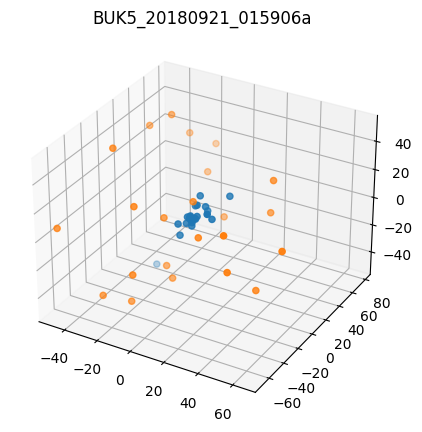

In [46]:
basePath = "./out_numpy_4CNN_Block_mutitask"
waveFramePath = "./waveFrame/"
PathSet = get_Hash_path(basePath)
plot_scatter('BUK5_20180921_015906a',basePath=basePath,waveFramePath=waveFramePath,PathSet=PathSet)

./out_numpy_4CNN_Block_singleTask/BUK5_20180921_015906a/s_embedding.numpy.npy
./out_numpy_4CNN_Block_singleTask/BUK5_20180921_015906a/y_s.numpy.npy
./out_numpy_4CNN_Block_singleTask/BUK5_20180921_015906a/q_embedding.numpy.npy
start pca!
pca finished!
BUK5_20180921_015906a


/tmp/ipykernel_65252/3615415920.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter3D(neg_[:,0], neg_[:,1], neg_[:,2], cmap='r')
/tmp/ipykernel_65252/3615415920.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter3D(pos_[:,0], pos_[:,1], pos_[:,2], cmap='b')


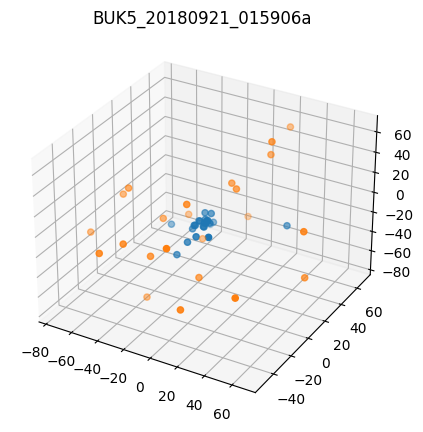

In [47]:
basePath = "./out_numpy_4CNN_Block_singleTask"
waveFramePath = "./waveFrame/"
PathSet = get_Hash_path(basePath)
plot_scatter('BUK5_20180921_015906a',basePath=basePath,waveFramePath=waveFramePath,PathSet=PathSet)

In [61]:
class one():
    def __init__(self, *args):
        super(one, self).__init__(*args)
        self.consistence=1
        self.consistence_ramup=10
        
    def sigmoid_ramup(self,current,rampup_length):
            if rampup_length==0:
                return 1.0
            else:
                current = np.clip(current,0.0,rampup_length)
                phase = 1.0 - current / rampup_length
                return float(np.exp(-5.0*phase*phase))

    def get_current_consistency_weight(self,index):
        return self.consistence * self.sigmoid_ramup(index,self.consistence_ramup)

In [62]:
target = one()
weight_array = [target.get_current_consistency_weight(i) for i in range(10)]


In [73]:
q=torch.randn(10,125,431,2)
weight_array=torch.tensor(weight_array)
q_list =(q*weight_array[:,None,None,None]).sum(0)

/tmp/ipykernel_65252/2340470631.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_array=torch.tensor(weight_array)


In [74]:
q_list.shape

torch.Size([125, 431, 2])

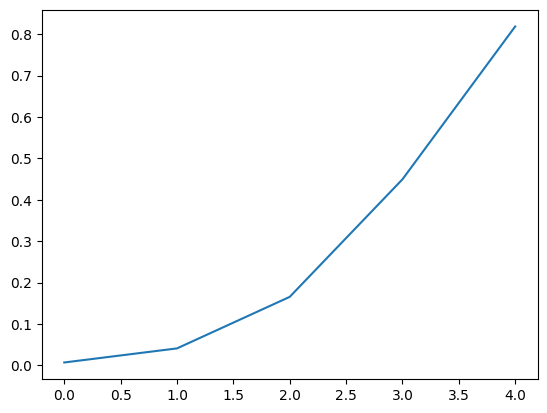

In [51]:
plt.plot(phase_list)

In [86]:
def removeElement(nums, val):
    """
    :type nums: List[int]
    :type val: int
    :rtype: int
    """
    ans=0
    print(nums)
    for i in range(len(nums)):
        if nums[i]!=val:
            print(ans)
            nums[ans]=nums[i]
            ans+=1
    # print(nums)
    print(nums)
    return len(nums)-ans

In [87]:
a=[3,2,2,3]
b=3
removeElement(a,b)

[3, 2, 2, 3]
0
1
[2, 2, 2, 3]


2

In [91]:
def sortedSquares(nums: list[int]) -> list[int]:
    n = len(nums)
    i,j,k = 0,n - 1,n - 1
    ans = [-1] * n
    while i <= j:
        lm = nums[i] ** 2
        rm = nums[j] ** 2
        if lm > rm:
            ans[k] = lm
            i += 1
        else:
            ans[k] = rm
            j -= 1
        k -= 1
    return ans

In [92]:
a=[1,-1,0,-9,5,12]
sortedSquares(a)

[0, 1, 1, 81, 25, 144]

In [3]:
import librosa

In [4]:
_,y = librosa.load("/media/b227/ygw/Dcase2023/data/Development_Set/Training_Set/HT/a1.wav")

In [1]:
import torch

/home/b227/anaconda3/envs/ygw/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
